# Llama 2 vs Llama 3

### Import Libraries

In [1]:
from generator.generator import Generator
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import utils

llama2 = Generator(model='llama2')
llama3 = Generator(model='llama3')

/Users/rafael/miniconda3/envs/zaai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /Users/rafael/Documents/lab/large-language-models/llama-3/model/nous-hermes-llama-2-7b.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:            

### Load Q&A Data 

In [2]:
squad = load_dataset("squad", split="train")
squad = squad.shuffle()

### Create dictionary to save metrics

In [3]:
llama2_metrics = {
    "words_per_second": [],
    "words": [],
}

llama3_metrics = {
    "words_per_second": [],
    "words": [],
}

### Gather metrics

In [6]:
for i in range(30):
    context = squad[i]['context']
    query = squad[i]['question']
    answer = squad[i]['answers']['text'][0]

    # llama 2
    answer_llama2, words_per_second, words = utils.get_llm_response(llama2, context, query)
    llama2_metrics["words_per_second"].append(words_per_second)
    llama2_metrics["words"].append(words)

    # llama 3
    answer_llama3, words_per_second, words = utils.get_llm_response(llama3, context, query)
    llama3_metrics["words_per_second"].append(words_per_second)
    llama3_metrics["words"].append(words)
    


llama_print_timings:        load time =   16375.34 ms
llama_print_timings:      sample time =       0.54 ms /     1 runs   (    0.54 ms per token,  1848.43 tokens per second)
llama_print_timings: prompt eval time =  102337.42 ms /   463 tokens (  221.03 ms per token,     4.52 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =  102559.97 ms /   464 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    4174.89 ms
llama_print_timings:      sample time =    1026.29 ms /   639 runs   (    1.61 ms per token,   622.63 tokens per second)
llama_print_timings: prompt eval time =  141897.93 ms /   366 tokens (  387.70 ms per token,     2.58 tokens per second)
llama_print_timings:        eval time =  250747.35 ms /   638 runs   (  393.02 ms per token,     2.54 tokens per second)
llama_print_timings:       total time =  406870.71 ms /  1004 

### Metrics comparison

#### Llama 2 7B vs Llama 3 8B

In [7]:
llama2_metrics = pd.DataFrame(llama2_metrics)
llama2_metrics['model'] = 'Llama 2 7B'
llama3_metrics = pd.DataFrame(llama3_metrics)
llama3_metrics['model'] = 'Llama 3 8B'

# create single data frame for plotting
metrics = pd.concat([llama2_metrics, llama3_metrics])

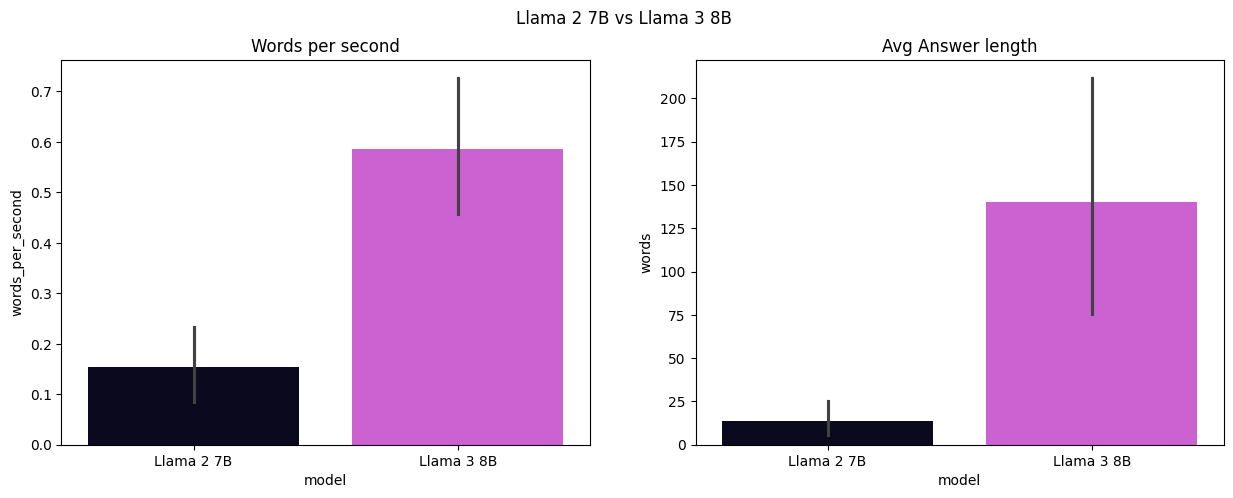

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Llama 2 7B vs Llama 3 8B')

sns.barplot(ax=axes[0], data=metrics, y='words_per_second', x='model', hue='model', palette=["#070620", "#dd4fe4"])
axes[0].set_title("Words per second")

sns.barplot(ax=axes[1], data=metrics, y='words', x='model', hue='model', palette=["#070620", "#dd4fe4"])
axes[1].set_title("Avg Answer length")

plt.show()